In [80]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import skew
from scipy.stats import multinomial

from variance import *

# Living in S(h)B where direct hits now exist

## Functions to simulate damage

In [26]:
def hits2pot(x, l_c, l_d, d2, buffs=None):
    """
    Convert a vector of non-DoT hit types to damage

    Inputs:
    x: 4 x n_trials list/numpy array, vector containing number of each hit type, [normal hits, crit hits, direct hits, crit-direct hits].
    l_c: float, critical hit damage multiplier, starting from 1000.
    l_d: float, direct hit multiplier, usually 125
    d2: float, base D2 damage value
    buffs: list/numpy array, vector of buff multipliers, e.g. [1.1, 1.05, ...]. If none, no buffs are used.

    Returns:
    damage dealt, vector with n_trials elements 
    """

    if buffs is None:
        buff_prod = 1
    else:
        buff_prod = np.prod(buffs)

    n_trials = x[:,0].size
    potency = np.zeros(n_trials)

    a_n, b_n = get_nh_bounds(d2)
    a_c, b_c = get_ch_bounds(d2, l_c)
    a_d, b_d = get_dh_bounds(d2, l_d)
    a_cd, b_cd = get_cdh_bounds(d2, l_c, l_d)

    # This is a prime example of how for loops are slow
    # using numpy broadcasting would be much faster, but would take some more effort.
    for a in range(n_trials):
        nh_dmg  = np.floor(np.random.randint(a_n,  b_n,  size=(x[a,0])) * buff_prod)
        ch_dmg  = np.floor(np.random.randint(a_c,  b_c,  size=(x[a,1])) * buff_prod)
        dh_dmg  = np.floor(np.random.randint(a_d,  b_d,  size=(x[a,2])) * buff_prod)
        cdh_dmg = np.floor(np.random.randint(a_cd, b_cd, size=(x[a,3])) * buff_prod)
        
        potency[a] = np.sum(nh_dmg) + np.sum(ch_dmg) + np.sum(dh_dmg) + np.sum(cdh_dmg)

    return potency

def dots2pot(x, l_c, l_d, d2, buffs=None):
    """
    Convert a vector of DoT hit types to damage

    Inputs:
    x: 4 x n_trials list/numpy array, vector containing number of each hit type, [normal hits, crit hits, direct hits, crit-direct hits].
    l_c: float, critical hit damage multiplier, starting from 1000.
    l_d: float, direct hit multiplier, usually 125
    d2: float, base D2 damage value
    buffs: list/numpy array, vector of buff multipliers, e.g. [1.1, 1.05, ...]. If none, no buffs are used.

    Returns:
    damage dealt, vector with n_trials elements 
    """

    if buffs is None:
        buff_prod = 1
    else:
        buff_prod = np.prod(buffs)
    
    n_trials = x[:,0].size
    potency = np.zeros(n_trials)
    a_n, b_n = get_nh_bounds(d2)

    for a in range(n_trials):
        nh_dmg  = np.floor(np.random.randint(a_n, b_n, size=(x[a,0])) * buff_prod)
        ch_dmg  = np.floor(np.floor(np.floor(np.random.randint(a_n, b_n, size=(x[a,1])) * l_c) / 1000) * buff_prod)
        dh_dmg  = np.floor(np.floor(np.floor(np.random.randint(a_n, b_n, size=(x[a,2])) * l_d) / 100) * buff_prod)

        cdh1 = np.floor(np.floor(np.random.randint(a_n, b_n, size=(x[a,3])) * l_c) / 1000)
        cdh_dmg = np.floor(np.floor(np.floor(cdh1 * l_d) / 100) * buff_prod)
        
        potency[a] = np.sum(nh_dmg) + np.sum(ch_dmg) + np.sum(dh_dmg) + np.sum(cdh_dmg)    

    return potency

## Functions to exactly compute moments

These aren't terribly efficient at the moment. Computing higher moments requires the lower moments, which will end up getting recomputed. For example, if the mean, variance, and skewness are all computed, the mean is computed three times; once for the mean, once for the variance, and a third time for the skewness. This can get expensive when the number of hits is over 50 because the number of hit type combinations that sum to 50 grows combinatorically.

A better way would be make functions for each deriviative of the MGF and then make a function that computes the mean, variance, and skewness all at once.

It'd be cleaner if the functions had an option to specifiy if the action is a DoT and compute the correct s/Z values accordingly.


In [27]:
def skill_mean(d2, n, l_c, l_d, p, buffs=None):
    """
    Compute the exact mean of a non-DoT action landing n hits.

    Inputs:
    d2: float, D2 value of the action
    n: int, total number of hits
    l_c: float, critical hit damage multiplier, starting from 1000.
    l_d: float, direct hit multiplier, usually 125
    p: list/np array, probability of each hit type
    buffs: list/numpy array, vector of buff multipliers, e.g. [1.1, 1.05, ...]. If none, no buffs are used.

    returns:
    mean of the damage distribution
    """
    normal_supp = nh_supp(d2, buffs)
    S_N = normal_supp.size
    Z_N = np.sum(normal_supp)

    crit_supp = ch_supp(d2, l_c, buffs)
    S_C = crit_supp.size
    Z_C = np.sum(crit_supp)

    dir_supp = dh_supp(d2, l_d, buffs)
    S_D = dir_supp.size
    Z_D = np.sum(dir_supp)

    crit_dir_supp = cdh_supp(d2, l_c, l_d, buffs)
    S_CD = crit_dir_supp.size
    Z_CD = np.sum(crit_dir_supp)

    w = multinomial(n, p).pmf(hit_type_combos(n))
    x = hit_type_combos(n)

    # Making this (and the mean) vectorized is ~40x faster than loops. very important.
    # The efficient itertools implementation for hit_type_combos is probably at least 1-2 oom speedup
    # given how inefficient loops are in python
    mean = ((x[:,1]*Z_C)/S_C + (x[:,3]*Z_CD)/S_CD + (x[:,2]*Z_D)/S_D + (x[:,0]*Z_N)/S_N)
    mean = np.dot(w, mean)
    return mean

def skill_var(d2, n, l_c, l_d, p, buffs=None):
    """
    Compute the exact variance of a non-DoT action landing n hits.

    Inputs:
    d2: float, D2 value of the action
    n: int, total number of hits
    l_c: float, critical hit damage multiplier, starting from 1000.
    l_d: float, direct hit multiplier, usually 125
    p: list/np array, probability of each hit type
    buffs: list/numpy array, vector of buff multipliers, e.g. [1.1, 1.05, ...]. If none, no buffs are used.

    returns:
    mean of the damage distribution
    """
    normal_supp = nh_supp(d2, buffs)
    S_N = normal_supp.size
    Z_N = np.sum(normal_supp)
    Z_N2 = np.sum(normal_supp**2)

    crit_supp = ch_supp(d2, l_c, buffs)
    S_C = crit_supp.size
    Z_C = np.sum(crit_supp)
    Z_C2 = np.sum(crit_supp**2)

    dir_supp = dh_supp(d2, l_d, buffs)
    S_D = dir_supp.size
    Z_D = np.sum(dir_supp)
    Z_D2 = np.sum(dir_supp**2)

    crit_dir_supp = cdh_supp(d2, l_c, l_d, buffs)
    S_CD = crit_dir_supp.size
    Z_CD = np.sum(crit_dir_supp)
    Z_CD2 = np.sum(crit_dir_supp**2)

    w = multinomial(n, p).pmf(hit_type_combos(n))
    x = hit_type_combos(n)
    second_deriv = ((x[:,1]**2*Z_C**2)/S_C**2 + (x[:,3]**2*Z_CD**2)/S_CD**2 \
                    + x[:,3]*(-(Z_CD**2/S_CD**2) + Z_CD2/S_CD) + (x[:,2]**2*Z_D**2)/S_D**2 \
                    + x[:,1]*(-(Z_C**2/S_C**2) + Z_C2/S_C + (2*x[:,3]*Z_C*Z_CD)/(S_C*S_CD) \
                    + (2*x[:,2]*Z_C*Z_D)/(S_C*S_D)) + x[:,2]*((2*x[:,3]*Z_CD*Z_D)/(S_CD*S_D) \
                    - Z_D**2/S_D**2 + Z_D2/S_D) + (x[:,0]**2*Z_N**2)/S_N**2 \
                    + x[:,0]*((2*x[:,1]*Z_C*Z_N)/(S_C*S_N) + (2*x[:,3]*Z_CD*Z_N)/(S_CD*S_N)\
                    + (2*x[:,2]*Z_D*Z_N)/(S_D*S_N) - Z_N**2/S_N**2 + Z_N2/S_N))
    second_deriv = np.dot(w, second_deriv)
    return second_deriv - skill_mean(d2, n, l_c, l_d, p, buffs)**2

def skill_skewness(d2, n, l_c, l_d, p, buffs=None):
    """
    Compute the exact skewness of a non-DoT action landing n hits.
    Pearson's definition of skewness is used

    Inputs:
    d2: float, D2 value of the action
    n: int, total number of hits
    l_c: float, critical hit damage multiplier, starting from 1000.
    l_d: float, direct hit multiplier, usually 125
    p: list/np array, probability of each hit type
    buffs: list/numpy array, vector of buff multipliers, e.g. [1.1, 1.05, ...]. If none, no buffs are used.

    returns:
    skewness of the damage distribution
    """
    normal_supp = nh_supp(d2, buffs)
    S_N = normal_supp.size
    Z_N  = np.sum(normal_supp)
    Z_N2 = np.sum(normal_supp**2)
    Z_N3 = np.sum(normal_supp**3)

    crit_supp = ch_supp(d2, l_c, buffs)
    S_C = crit_supp.size
    Z_C  = np.sum(crit_supp)
    Z_C2 = np.sum(crit_supp**2)
    Z_C3 = np.sum(crit_supp**3)

    dir_supp = dh_supp(d2, l_d, buffs)
    S_D = dir_supp.size
    Z_D  = np.sum(dir_supp)
    Z_D2 = np.sum(dir_supp**2)
    Z_D3 = np.sum(dir_supp**3)

    crit_dir_supp = cdh_supp(d2, l_c, l_d, buffs)
    S_CD  = crit_dir_supp.size
    Z_CD  = np.sum(crit_dir_supp)
    Z_CD2 = np.sum(crit_dir_supp**2)
    Z_CD3 = np.sum(crit_dir_supp**3)

    w = multinomial(n, p).pmf(hit_type_combos(n))
    x = hit_type_combos(n)

    third_deriv = ((x[:,1]**3*Z_C**3)/S_C**3 + (x[:,3]**3*Z_CD**3)/S_CD**3 \
                  + x[:,3]**2*((-3*Z_CD**3)/S_CD**3 + (3*Z_CD*Z_CD2)/S_CD**2) \
                  + x[:,3]*((2*Z_CD**3)/S_CD**3 - (3*Z_CD*Z_CD2)/S_CD**2 + Z_CD3/S_CD) \
                  + (x[:,2]**3*Z_D**3)/S_D**3 + x[:,1]**2*((-3*Z_C**3)/S_C**3 \
                  + (3*Z_C*Z_C2)/S_C**2 + (3*x[:,3]*Z_C**2*Z_CD)/(S_C**2*S_CD) 
                  + (3*x[:,2]*Z_C**2*Z_D)/(S_C**2*S_D)) + x[:,2]**2*((3*x[:,3]*Z_CD*Z_D**2)/(S_CD*S_D**2) \
                  - (3*Z_D**3)/S_D**3 + (3*Z_D*Z_D2)/S_D**2) + x[:,1]*((2*Z_C**3)/S_C**3 \
                  - (3*Z_C*Z_C2)/S_C**2 + Z_C3/S_C + (3*x[:,3]**2*Z_C*Z_CD**2)/(S_C*S_CD**2) \
                  + x[:,3]*((-3*Z_C**2*Z_CD)/(S_C**2*S_CD) + (3*Z_C2*Z_CD)/(S_C*S_CD) \
                  - (3*Z_C*Z_CD**2)/(S_C*S_CD**2) + (3*Z_C*Z_CD2)/(S_C*S_CD)) + (3*x[:,2]**2*Z_C*Z_D**2)/(S_C*S_D**2) \
                  + x[:,2]*((-3*Z_C**2*Z_D)/(S_C**2*S_D) + (3*Z_C2*Z_D)/(S_C*S_D) + (6*x[:,3]*Z_C*Z_CD*Z_D)/(S_C*S_CD*S_D)\
                  - (3*Z_C*Z_D**2)/(S_C*S_D**2) + (3*Z_C*Z_D2)/(S_C*S_D))) + x[:,2]*((3*x[:,3]**2*Z_CD**2*Z_D)/(S_CD**2*S_D) \
                  + (2*Z_D**3)/S_D**3 - (3*Z_D*Z_D2)/S_D**2 + x[:,3]*((-3*Z_CD**2*Z_D)/(S_CD**2*S_D) \
                  + (3*Z_CD2*Z_D)/(S_CD*S_D) - (3*Z_CD*Z_D**2)/(S_CD*S_D**2) + (3*Z_CD*Z_D2)/(S_CD*S_D)) + Z_D3/S_D) \
                  + (x[:,0]**3*Z_N**3)/S_N**3 + x[:,0]**2*((3*x[:,1]*Z_C*Z_N**2)/(S_C*S_N**2) \
                  + (3*x[:,3]*Z_CD*Z_N**2)/(S_CD*S_N**2) + (3*x[:,2]*Z_D*Z_N**2)/(S_D*S_N**2) \
                  - (3*Z_N**3)/S_N**3 + (3*Z_N*Z_N2)/S_N**2) + x[:,0]*((3*x[:,1]**2*Z_C**2*Z_N)/(S_C**2*S_N) \
                  + (3*x[:,3]**2*Z_CD**2*Z_N)/(S_CD**2*S_N) + (3*x[:,2]**2*Z_D**2*Z_N)/(S_D**2*S_N) \
                  + (2*Z_N**3)/S_N**3 - (3*Z_N*Z_N2)/S_N**2 + x[:,1]*((-3*Z_C**2*Z_N)/(S_C**2*S_N) \
                  + (3*Z_C2*Z_N)/(S_C*S_N) + (6*x[:,3]*Z_C*Z_CD*Z_N)/(S_C*S_CD*S_N) + (6*x[:,2]*Z_C*Z_D*Z_N)/(S_C*S_D*S_N) \
                  - (3*Z_C*Z_N**2)/(S_C*S_N**2) + (3*Z_C*Z_N2)/(S_C*S_N)) + x[:,3]*((-3*Z_CD**2*Z_N)/(S_CD**2*S_N) \
                  + (3*Z_CD2*Z_N)/(S_CD*S_N) - (3*Z_CD*Z_N**2)/(S_CD*S_N**2) + (3*Z_CD*Z_N2)/(S_CD*S_N)) \
                  + x[:,2]*((6*x[:,3]*Z_CD*Z_D*Z_N)/(S_CD*S_D*S_N) - (3*Z_D**2*Z_N)/(S_D**2*S_N) + (3*Z_D2*Z_N)/(S_D*S_N) \
                  - (3*Z_D*Z_N**2)/(S_D*S_N**2) + (3*Z_D*Z_N2)/(S_D*S_N)) + Z_N3/S_N))

    third_deriv = np.dot(w, third_deriv)
    
    mean = skill_mean(d2, n, l_c, l_d, p, buffs)
    std =  np.sqrt(skill_var(d2, n, l_c, l_d, p, buffs))
    
    return (third_deriv - 3*mean*std**2 - mean**3) / std**3

In [28]:
def dot_mean(d2, n, l_c, l_d, p, buffs=None):
    """
    Compute the exact mean of a DoT action landing n hits.
    Pearson's definition of skewness is used

    Inputs:
    d2: float, D2 value of the action
    n: int, total number of hits
    l_c: float, critical hit damage multiplier, starting from 1000.
    l_d: float, direct hit multiplier, usually 125
    p: list/np array, probability of each hit type
    buffs: list/numpy array, vector of buff multipliers, e.g. [1.1, 1.05, ...]. If none, no buffs are used.

    returns:
    mean of the damage distribution
    """
    
    normal_supp = dot_nh_supp(d2, buffs)
    S_N = normal_supp.size
    Z_N = np.sum(normal_supp)

    crit_supp = dot_ch_supp(d2, l_c, buffs)
    S_C = crit_supp.size
    Z_C = np.sum(crit_supp)

    dir_supp = dot_dh_supp(d2, l_d, buffs)
    S_D = dir_supp.size
    Z_D = np.sum(dir_supp)

    crit_dir_supp = dot_cdh_supp(d2, l_c, l_d, buffs)
    S_CD = crit_dir_supp.size
    Z_CD = np.sum(crit_dir_supp)

    w = multinomial(n, p).pmf(hit_type_combos(n))
    x = hit_type_combos(n)

    mean = ((x[:,1]*Z_C)/S_C + (x[:,3]*Z_CD)/S_CD + (x[:,2]*Z_D)/S_D + (x[:,0]*Z_N)/S_N)
    mean = np.dot(w, mean)
    return mean


def dot_var(d2, n, l_c, l_d, p, buffs=None):
    """
    Compute the exact variance of a DoT action landing n hits.
    Pearson's definition of skewness is used

    Inputs:
    d2: float, D2 value of the action
    n: int, total number of hits
    l_c: float, critical hit damage multiplier, starting from 1000.
    l_d: float, direct hit multiplier, usually 125
    p: list/np array, probability of each hit type
    buffs: list/numpy array, vector of buff multipliers, e.g. [1.1, 1.05, ...]. If none, no buffs are used.

    returns:
    variance of the damage distribution
    """

    normal_supp = dot_nh_supp(d2, buffs)
    S_N = normal_supp.size
    Z_N = np.sum(normal_supp)
    Z_N2 = np.sum(normal_supp**2)

    crit_supp = dot_ch_supp(d2, l_c, buffs)
    S_C = crit_supp.size
    Z_C = np.sum(crit_supp)
    Z_C2 = np.sum(crit_supp**2)

    dir_supp = dot_dh_supp(d2, l_d, buffs)
    S_D = dir_supp.size
    Z_D = np.sum(dir_supp)
    Z_D2 = np.sum(dir_supp**2)

    crit_dir_supp = dot_cdh_supp(d2, l_c, l_d, buffs)
    S_CD = crit_dir_supp.size
    Z_CD = np.sum(crit_dir_supp)
    Z_CD2 = np.sum(crit_dir_supp**2)

    w = multinomial(n, p).pmf(hit_type_combos(n))
    x = hit_type_combos(n)
    second_deriv = ((x[:,1]**2*Z_C**2)/S_C**2 + (x[:,3]**2*Z_CD**2)/S_CD**2 \
                    + x[:,3]*(-(Z_CD**2/S_CD**2) + Z_CD2/S_CD) + (x[:,2]**2*Z_D**2)/S_D**2 \
                    + x[:,1]*(-(Z_C**2/S_C**2) + Z_C2/S_C + (2*x[:,3]*Z_C*Z_CD)/(S_C*S_CD) \
                    + (2*x[:,2]*Z_C*Z_D)/(S_C*S_D)) + x[:,2]*((2*x[:,3]*Z_CD*Z_D)/(S_CD*S_D) \
                    - Z_D**2/S_D**2 + Z_D2/S_D) + (x[:,0]**2*Z_N**2)/S_N**2 \
                    + x[:,0]*((2*x[:,1]*Z_C*Z_N)/(S_C*S_N) + (2*x[:,3]*Z_CD*Z_N)/(S_CD*S_N)\
                    + (2*x[:,2]*Z_D*Z_N)/(S_D*S_N) - Z_N**2/S_N**2 + Z_N2/S_N))
    second_deriv = np.dot(w, second_deriv)
    return second_deriv - dot_mean(d2, n, l_c, l_d, p, buffs)**2

def dot_skewness(d2, n, l_c, l_d, p, buffs=None):
    """
    Compute the exact skewness of a DoT action landing n hits.
    Pearson's definition of skewness is used

    Inputs:
    d2: float, D2 value of the action
    n: int, total number of hits
    l_c: float, critical hit damage multiplier, starting from 1000.
    l_d: float, direct hit multiplier, usually 125
    p: list/np array, probability of each hit type
    buffs: list/numpy array, vector of buff multipliers, e.g. [1.1, 1.05, ...]. If none, no buffs are used.

    returns:
    skewness of the damage distribution
    """    
    normal_supp = dot_nh_supp(d2, buffs)
    S_N = normal_supp.size
    Z_N = np.sum(normal_supp)
    Z_N2 = np.sum(normal_supp**2)
    Z_N3 = np.sum(normal_supp**3)

    crit_supp = dot_ch_supp(d2, l_c, buffs)
    S_C = crit_supp.size
    Z_C = np.sum(crit_supp)
    Z_C2 = np.sum(crit_supp**2)
    Z_C3 = np.sum(crit_supp**3)

    dir_supp = dot_dh_supp(d2, l_d, buffs)
    S_D = dir_supp.size
    Z_D = np.sum(dir_supp)
    Z_D2 = np.sum(dir_supp**2)
    Z_D3 = np.sum(dir_supp**3)

    crit_dir_supp = dot_cdh_supp(d2, l_c, l_d, buffs)
    S_CD = crit_dir_supp.size
    Z_CD = np.sum(crit_dir_supp)
    Z_CD2 = np.sum(crit_dir_supp**2)
    Z_CD3 = np.sum(crit_dir_supp**3)

    w = multinomial(n, p).pmf(hit_type_combos(n))
    x = hit_type_combos(n)

    third_deriv = ((x[:,1]**3*Z_C**3)/S_C**3 + (x[:,3]**3*Z_CD**3)/S_CD**3 \
                  + x[:,3]**2*((-3*Z_CD**3)/S_CD**3 + (3*Z_CD*Z_CD2)/S_CD**2) \
                  + x[:,3]*((2*Z_CD**3)/S_CD**3 - (3*Z_CD*Z_CD2)/S_CD**2 + Z_CD3/S_CD) \
                  + (x[:,2]**3*Z_D**3)/S_D**3 + x[:,1]**2*((-3*Z_C**3)/S_C**3 \
                  + (3*Z_C*Z_C2)/S_C**2 + (3*x[:,3]*Z_C**2*Z_CD)/(S_C**2*S_CD) 
                  + (3*x[:,2]*Z_C**2*Z_D)/(S_C**2*S_D)) + x[:,2]**2*((3*x[:,3]*Z_CD*Z_D**2)/(S_CD*S_D**2) \
                  - (3*Z_D**3)/S_D**3 + (3*Z_D*Z_D2)/S_D**2) + x[:,1]*((2*Z_C**3)/S_C**3 \
                  - (3*Z_C*Z_C2)/S_C**2 + Z_C3/S_C + (3*x[:,3]**2*Z_C*Z_CD**2)/(S_C*S_CD**2) \
                  + x[:,3]*((-3*Z_C**2*Z_CD)/(S_C**2*S_CD) + (3*Z_C2*Z_CD)/(S_C*S_CD) \
                  - (3*Z_C*Z_CD**2)/(S_C*S_CD**2) + (3*Z_C*Z_CD2)/(S_C*S_CD)) + (3*x[:,2]**2*Z_C*Z_D**2)/(S_C*S_D**2) \
                  + x[:,2]*((-3*Z_C**2*Z_D)/(S_C**2*S_D) + (3*Z_C2*Z_D)/(S_C*S_D) + (6*x[:,3]*Z_C*Z_CD*Z_D)/(S_C*S_CD*S_D)\
                  - (3*Z_C*Z_D**2)/(S_C*S_D**2) + (3*Z_C*Z_D2)/(S_C*S_D))) + x[:,2]*((3*x[:,3]**2*Z_CD**2*Z_D)/(S_CD**2*S_D) \
                  + (2*Z_D**3)/S_D**3 - (3*Z_D*Z_D2)/S_D**2 + x[:,3]*((-3*Z_CD**2*Z_D)/(S_CD**2*S_D) \
                  + (3*Z_CD2*Z_D)/(S_CD*S_D) - (3*Z_CD*Z_D**2)/(S_CD*S_D**2) + (3*Z_CD*Z_D2)/(S_CD*S_D)) + Z_D3/S_D) \
                  + (x[:,0]**3*Z_N**3)/S_N**3 + x[:,0]**2*((3*x[:,1]*Z_C*Z_N**2)/(S_C*S_N**2) \
                  + (3*x[:,3]*Z_CD*Z_N**2)/(S_CD*S_N**2) + (3*x[:,2]*Z_D*Z_N**2)/(S_D*S_N**2) \
                  - (3*Z_N**3)/S_N**3 + (3*Z_N*Z_N2)/S_N**2) + x[:,0]*((3*x[:,1]**2*Z_C**2*Z_N)/(S_C**2*S_N) \
                  + (3*x[:,3]**2*Z_CD**2*Z_N)/(S_CD**2*S_N) + (3*x[:,2]**2*Z_D**2*Z_N)/(S_D**2*S_N) \
                  + (2*Z_N**3)/S_N**3 - (3*Z_N*Z_N2)/S_N**2 + x[:,1]*((-3*Z_C**2*Z_N)/(S_C**2*S_N) \
                  + (3*Z_C2*Z_N)/(S_C*S_N) + (6*x[:,3]*Z_C*Z_CD*Z_N)/(S_C*S_CD*S_N) + (6*x[:,2]*Z_C*Z_D*Z_N)/(S_C*S_D*S_N) \
                  - (3*Z_C*Z_N**2)/(S_C*S_N**2) + (3*Z_C*Z_N2)/(S_C*S_N)) + x[:,3]*((-3*Z_CD**2*Z_N)/(S_CD**2*S_N) \
                  + (3*Z_CD2*Z_N)/(S_CD*S_N) - (3*Z_CD*Z_N**2)/(S_CD*S_N**2) + (3*Z_CD*Z_N2)/(S_CD*S_N)) \
                  + x[:,2]*((6*x[:,3]*Z_CD*Z_D*Z_N)/(S_CD*S_D*S_N) - (3*Z_D**2*Z_N)/(S_D**2*S_N) + (3*Z_D2*Z_N)/(S_D*S_N) \
                  - (3*Z_D*Z_N**2)/(S_D*S_N**2) + (3*Z_D*Z_N2)/(S_D*S_N)) + Z_N3/S_N))

    third_deriv = np.dot(w, third_deriv)
    
    mean = dot_mean(d2, n, l_c, l_d, p, buffs)
    std =  np.sqrt(dot_var(d2, n, l_c, l_d, p, buffs))
    
    return (third_deriv - 3*mean*std**2 - mean**3) / std**3

In [29]:
def rotation_mean(d, n, l_c, d_c, p, is_dot, buffs=None):
    """
    Get the mean of a rotation

    inputs:
    d - list/np array, array of D2 values
    n - list/np array, array of how many hits each action lands
    l_c - critical hit damage modifier, starts at 1000
    l_d - direct hit damage modifer, sould be 125
    p - probability of each hit type, from `get_p_vector`
    is_dot - list of bools, whether the hit is a DoT attack
    buffs - list of lists, damage multiplier of the buffs for each hit

    returns:
    mean of rotation
    """
    if buffs is None:
        buffs = [None] * len(n)
    return sum([dot_mean(d[x], n[x], l_c, d_c, p, buffs[x]) if is_dot[x] else skill_mean(d[x], n[x], l_c, d_c, p, buffs[x]) for x in range(len(n))])

def rotation_var(d, n, l_c, d_c, p, is_dot, buffs=None):
    """
    Get the variance of a rotation

    inputs:
    d - list/np array, array of D2 values
    n - list/np array, array of how many hits each action lands
    l_c - critical hit damage modifier, starts at 1000
    l_d - direct hit damage modifer, sould be 125
    p - probability of each hit type, from `get_p_vector`
    is_dot - list of bools, whether the hit is a DoT attack
    buffs - list of lists, damage multiplier of the buffs for each hit

    returns:
    variance of rotation
    """
    if buffs is None:
        buffs = [None] * len(n)
    return sum([dot_var(d[x], n[x], l_c, d_c, p, buffs[x]) if is_dot[x] else skill_var(d[x], n[x], l_c, d_c, p, buffs[x]) for x in range(len(n))])

def rotation_skew(d, n, l_c, d_c, p, is_dot, buffs=None):
    """
    Get the Pearson's skewness of a rotation

    This is super hacky because the moments are heavily embedded in functions.
    The numerator is sum(skew(m) * var(m)**(3/2)
    The rotation skewness is then sum(skew(m) * var(m)**(3/2)) / sum(var(m))**(3/2)

    inputs:
    d - list/np array, array of D2 values
    n - list/np array, array of how many hits each action lands
    l_c - critical hit damage modifier, starts at 1000
    l_d - direct hit damage modifer, sould be 125
    p - probability of each hit type, from `get_p_vector`
    is_dot - list of bools, whether the hit is a DoT attack
    buffs - list of lists, damage multiplier of the buffs for each hit

    returns:
    skewness of rotation
    """
    if buffs is None:
        buffs = [None] * len(n)
    pre_skew = np.array([dot_skewness(d[x], n[x], l_c, d_c, p, buffs[x]) if is_dot[x] else skill_skewness(d[x], n[x], l_c, d_c, p,  buffs[x]) for x in range(len(n))])
    variances = np.array([dot_var(d[x], n[x], l_c, d_c, p, buffs[x]) if is_dot[x] else skill_var(d[x], n[x], l_c, d_c, p, buffs[x]) for x in range(len(n))])

    pre_skew *= variances**(3/2)
    return np.sum(pre_skew) / np.sum(variances)**(3/2)

In [30]:
def get_p_vector(p_c, p_d, keep_cd=True):
    """
    Get the probability of each hit type occuring given the probability of a critical hit and direct hit

    inputs:
    p_c: probability of a critical hit landing
    p_d: probability of a direct hit landing
    keep_cd: bool, allow critical-direct hits. If true, the probability is p_c*p_d, otherwise 0

    returns:
    probability of each hit type, [normal hit, critical hit given not CD hit, direct hit given not CD hit, CD hit]
    """

    # Sometimes the probabilities don't sum to exactly 1.0 because of floating point error.
    # Sometimes SciPy's multinomial class will break because of that and just return NaN for probabilities.
    # Using the Decimal class with arbitrary precision and then converting them back to a float remedies this I guess.
    # Floating point math is stupid.
    from decimal import Decimal
    p_c = Decimal(p_c)
    p_d = Decimal(p_d)
    if keep_cd:
        p_cd = Decimal(p_c) * Decimal(p_d)
    
    else:
        p_cd = Decimal(0)

    return np.array([float(Decimal(1.0) - p_c - p_d + p_cd), float(p_c - p_cd), float(p_d - p_cd), float(p_cd)])

get_p_vector(0.2, 0.3)

array([0.56, 0.14, 0.24, 0.06])

## Non-DoT damage, 1 and 2 hits

Simulated damage distributions

In [31]:
p_c = 0.35
p_d = 0.2

p = get_p_vector(p_c, p_d)

# Multipliers
l_c = 1500
l_d = 125

d2 = 100

# buff list
b = [1.1]
p

array([0.52, 0.28, 0.13, 0.07])

In [32]:
x_vals1 = np.random.multinomial(1, p, 1000000)
x_vals2 = np.random.multinomial(2, p, 1000000)

dmg_dist1 = hits2pot(x_vals1, l_c, l_d, d2, b) 
dmg_dist2 = hits2pot(x_vals2, l_c, l_d, d2, b)

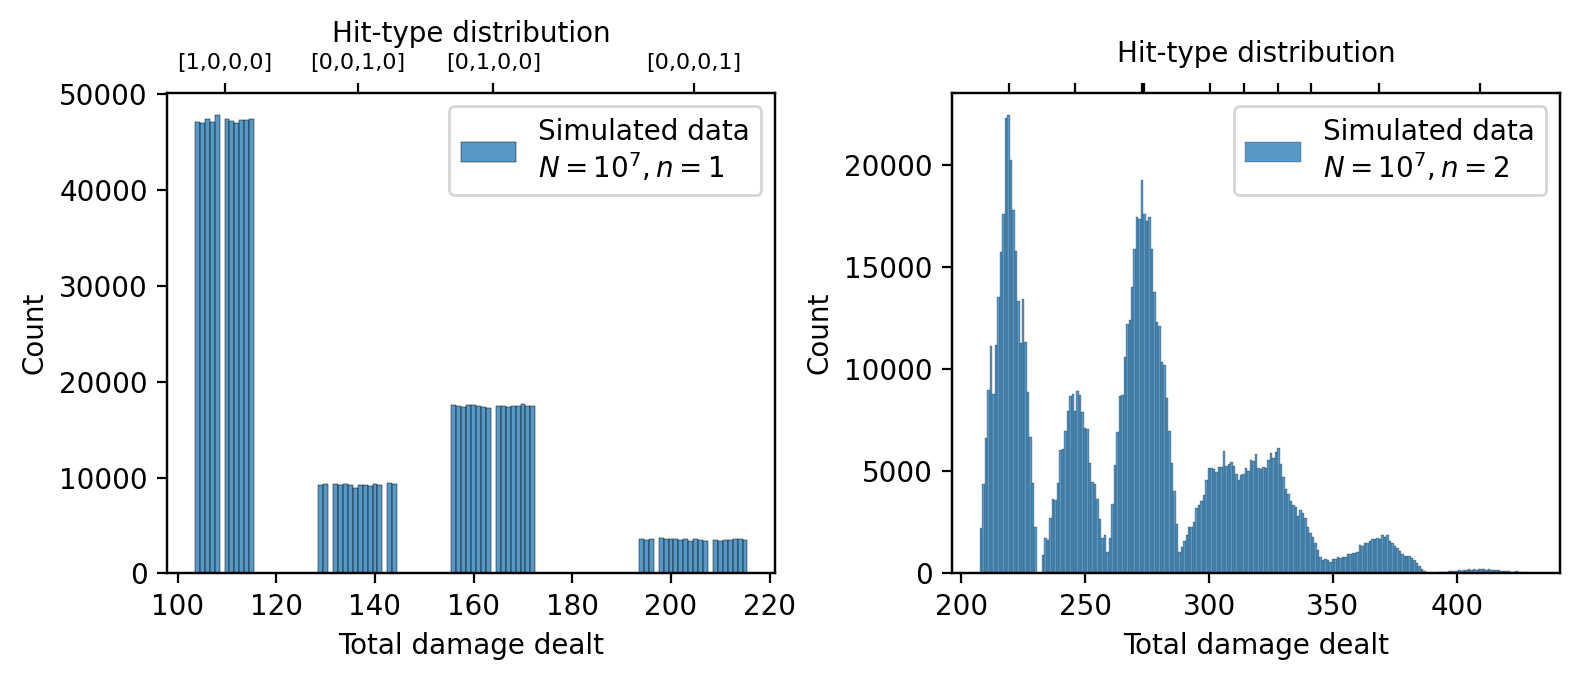

In [33]:
fig, ax = plt.subplots(1,2, figsize=(8,3.5), dpi=200, sharey=False)


n=1
d1 = 100
avg_dmg = [np.mean(x) for x in [nh_supp(d1, b), ch_supp(d1, l_c, b), dh_supp(d1, l_d, b), cdh_supp(d1, l_c, l_d, b)]]

sns.histplot(dmg_dist1, discrete=True, bins=150, ax=ax[0], label='Simulated data\n$N = 10^7, n=1$')
ax[0].set_xlabel('Total damage dealt')
ax2 = ax[0].twiny()
x_tick = np.sort(np.dot(hit_type_combos(n), avg_dmg))
x_label = ['']*x_tick.size

x_label = ['[1,0,0,0]', '[0,0,1,0]', '[0,1,0,0]', '[0,0,0,1]'] 

ax2.set_xlim(ax[0].get_xlim())
ax2.set_xticks(x_tick)
ax2.set_xticklabels(x_label)
ax2.set_xlabel('Hit-type distribution')
ax2.tick_params(axis='x', which='major', labelsize=8)

n=2
sns.histplot(dmg_dist2, discrete=True, bins=150, ax=ax[1], label='Simulated data\n$N = 10^7, n=2$')
ax[1].set_xlabel('Total damage dealt')

ax2 = ax[1].twiny()
x_tick = np.sort(np.dot(hit_type_combos(n), avg_dmg))
x_label = ['']*x_tick.size

ax2.set_xlim(ax[1].get_xlim())
ax2.set_xticks(x_tick)
ax2.set_xticklabels(x_label)
ax2.set_xlabel('Hit-type distribution')

ax[0].legend()
ax[1].legend()

plt.tight_layout()
plt.show()

In [34]:
x = dmg_dist2
n = 2

print('Sim mean:   {:5.3f} |'.format(np.mean(x)), 'Sim StD:   {:5.3f}'.format(np.std(x)))
print('Exact mean: {:5.3f} |'.format(skill_mean(d1, n, l_c, l_d, p, [1.1])), 'Exact StD: {:5.3f}'.format(skill_var(d1, n, l_c, l_d, p, [1.1])**(0.5)))
print('Sample skewness: {}'.format(skew(x)))
print('Exact skew: ', skill_skewness(d1, n, l_c, l_d, p, [1.1]))


Sim mean:   269.913 | Sim StD:   43.207
Exact mean: 269.915 | Exact StD: 43.176
Sample skewness: 0.5684338318273606
Exact skew:  0.5662296691516148


## DoT Damage

Simulated damage distributions

In [35]:
p_c = 0.35
p_d = 0.2

p = get_p_vector(p_c, p_d)

# Multipliers
l_c = 1500
l_d = 125

d2 = 100

n1 = 1
b = [1.1]
p

array([0.52, 0.28, 0.13, 0.07])

In [36]:
x_vals1 = np.random.multinomial(1, p, 1000000)
x_vals2 = np.random.multinomial(2, p, 1000000)

dot_dmg_dist1 = dots2pot(x_vals1, l_c, l_d, d2, b) 
dot_dmg_dist2 = dots2pot(x_vals2, l_c, l_d, d2, b)

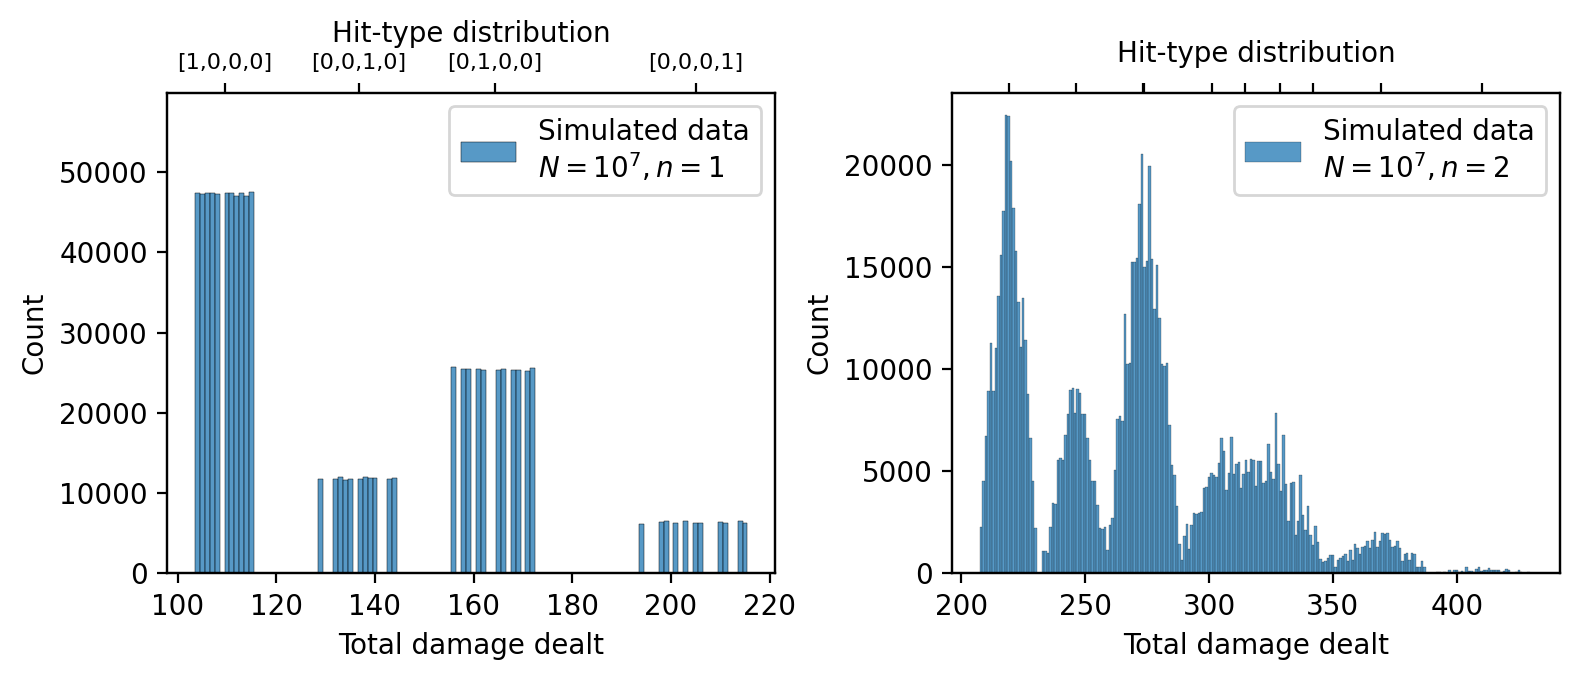

In [37]:
fig, ax = plt.subplots(1,2, figsize=(8,3.5), dpi=200, sharey=False)

avg_dmg = [np.mean(x) for x in [dot_nh_supp(d1, b), dot_ch_supp(d1, l_c, b), 
                                dot_dh_supp(d1, l_d, b), dot_cdh_supp(d1, l_c, l_d, b)]]

n=1
sns.histplot(dot_dmg_dist1, discrete=True, bins=150, ax=ax[0], label='Simulated data\n$N = 10^7, n=1$')
ax[0].set_xlabel('Total damage dealt')
ax2 = ax[0].twiny()
x_tick = np.sort(np.dot(hit_type_combos(n), avg_dmg))
x_label = ['[1,0,0,0]', '[0,0,1,0]', '[0,1,0,0]', '[0,0,0,1]'] 

ax[0].set_ylim(ax[0].get_ylim()[0], 1.2*ax[0].get_ylim()[1])

ax2.set_xlim(ax[0].get_xlim())
ax2.set_xticks(x_tick)
ax2.set_xticklabels(x_label)
ax2.tick_params(axis='x', which='major', labelsize=8)
ax2.set_xlabel('Hit-type distribution')


n=2
sns.histplot(dot_dmg_dist2, discrete=True, bins=150, ax=ax[1], label='Simulated data\n$N = 10^7, n=2$')
ax[1].set_xlabel('Total damage dealt')

ax2 = ax[1].twiny()
x_tick = np.sort(np.dot(hit_type_combos(n), avg_dmg))
x_label = ['']*x_tick.size

ax2.set_xlim(ax[1].get_xlim())
ax2.set_xticks(x_tick)
ax2.set_xticklabels(x_label)
ax2.set_xlabel('Hit-type distribution')

ax[0].legend()
ax[1].legend()

plt.tight_layout()
plt.show()

In [38]:
x = dot_dmg_dist2
n = 2

print('Sim mean:   {:5.3f} |'.format(np.mean(x)), 'Sim StD:   {:5.3f}'.format(np.std(x)))
print('Exact mean: {:5.3f} |'.format(dot_mean(d1, n, l_c, l_d, p, [1.1])), 'Exact StD: {:5.3f}'.format(dot_var(d1, n, l_c, l_d, p, [1.1])**(0.5)))
print('Sample skewness: {}'.format(skew(x)))
print('Exact skew: ', dot_skewness(d1, n, l_c, l_d, p, [1.1]))

Sim mean:   270.110 | Sim StD:   43.367
Exact mean: 270.182 | Exact StD: 43.381
Sample skewness: 0.565217645899041
Exact skew:  0.5654126710152044


# Example: 1 Skill, 1 DoT

In [39]:
# Det/Ten will enter here but I'm just assuming nice values
# because I dont want to code up everything needed to compute D2
d1 = 20000
d2 = 5000 # This is a dot

n1 = 50
n2 = 50

is_dot = [0, 1]

d = np.array([d1, d2])
n = np.array([n1, n2])

# I think this is one of the healer BiS
crit = 3731
dh = 1280

# Actually compute the proper crit rate and dmg modifier now
p_c = crit_prob(crit)
p_d = direct_hit_prob(dh)

p = get_p_vector(p_c, p_d)

l_c = crit_dmg_multiplier(crit)
l_d = 125

# Convert total dmg dealt to dps, assume 2.50s gcd
n_hits = 50
gcd = 2.5

dmg2dps = 1/(2.5*n_hits)
p

array([0.63495, 0.21505, 0.11205, 0.03795])

### Skewness for CH only

Didn't feel like adding the skewness function for the binomial function. Using the multinomial one with $p_D$ and $p_{CD}$ works fine, but is a bit inefficient

In [40]:
p_c = crit_prob(crit)
p_d = direct_hit_prob(380)

p_binom = get_p_vector(p_c, p_d)
print(p_binom)
print('skew: ', rotation_skew(d, n, l_c, l_d, p_binom, is_dot))

[0.747 0.253 0.    0.   ]
skew:  0.14849251504580294


In [41]:
# Simulate damage distribution
print(p)
x_1 = np.random.multinomial(n[0], p, 500000)
x_2 = np.random.multinomial(n[1], p, 500000)
rotation_dmg_dist =  hits2pot(x_1, l_c, l_d, d[0]) + dots2pot(x_2, l_c, l_d, d[1])

[0.63495 0.21505 0.11205 0.03795]


Compute exact moments and compare to sample moments

In [42]:

x = rotation_dmg_dist * dmg2dps

exact_mean =        rotation_mean(d, n, l_c, l_d, p, is_dot) * dmg2dps
exact_std  = np.sqrt(rotation_var(d, n, l_c, l_d, p, is_dot)) * dmg2dps
exact_rel_std = exact_std / exact_mean
exact_skew = rotation_skew(d, n, l_c, l_d, p, is_dot)

print('Sim mean:   {:5.3f} |'.format(np.mean(x)), 'Sim StD:   {:5.3f} |'.format(np.std(x)), 'Sim Skew:   {:1.3f}'.format(skew(x)))
print('Exact mean: {:5.3f} |'.format(exact_mean), 'Exact StD: {:5.3f} |'.format(exact_std), 'Exact Skew: {:1.3f}'.format(exact_skew))
print('{:0.4f}'.format(exact_rel_std))

# print('Skew: ', skew(x))

Sim mean:   11956.718 | Sim StD:   343.093 | Sim Skew:   0.162
Exact mean: 11957.717 | Exact StD: 342.715 | Exact Skew: 0.157
0.0287


## Okay but lets turn off critical direct hits now

In [43]:
crit = 3731
dh = 1280

p_c = crit_prob(crit)
p_d = direct_hit_prob(dh)

p = get_p_vector(p_c, p_d, keep_cd=False)
p

array([0.597, 0.253, 0.15 , 0.   ])

In [44]:
print(p)
x_1_noCDH = np.random.multinomial(n[0], p, 500000)
x_2_noCDH = np.random.multinomial(n[1], p, 500000)
rotation_dmg_dist_noCDH =  hits2pot(x_1_noCDH, l_c, l_d, d[0]) + dots2pot(x_2_noCDH, l_c, l_d, d[1])

[0.597 0.253 0.15  0.   ]


In [45]:
x = rotation_dmg_dist_noCDH * dmg2dps

exact_mean_noCDH =      rotation_mean(d, n, l_c, l_d, p, is_dot) * dmg2dps
exact_std_noCDH = np.sqrt(rotation_var(d, n, l_c, l_d, p, is_dot)) * dmg2dps
exact_rel_std_noCDH = exact_std_noCDH / exact_mean_noCDH
exact_skew_noCDH = rotation_skew(d, n, l_c, l_d, p, is_dot)


print('Sim mean:   {:5.3f} |'.format(np.mean(x)), 'Sim StD:   {:5.3f} |'.format(np.std(x)),  'Sim Skew:   {:1.3f}'.format(skew(x)))
print('Exact mean: {:5.3f} |'.format(exact_mean_noCDH), 'Exact StD: {:5.3f} |'.format(exact_std_noCDH), 'Exact Skew: {:1.3f}'.format(exact_skew_noCDH))
print('cv: {:0.4f}'.format(exact_rel_std_noCDH))
# print('Skew: ', skew(x))

Sim mean:   11900.772 | Sim StD:   300.523 | Sim Skew:   0.110
Exact mean: 11900.517 | Exact StD: 300.688 | Exact Skew: 0.108
cv: 0.0253


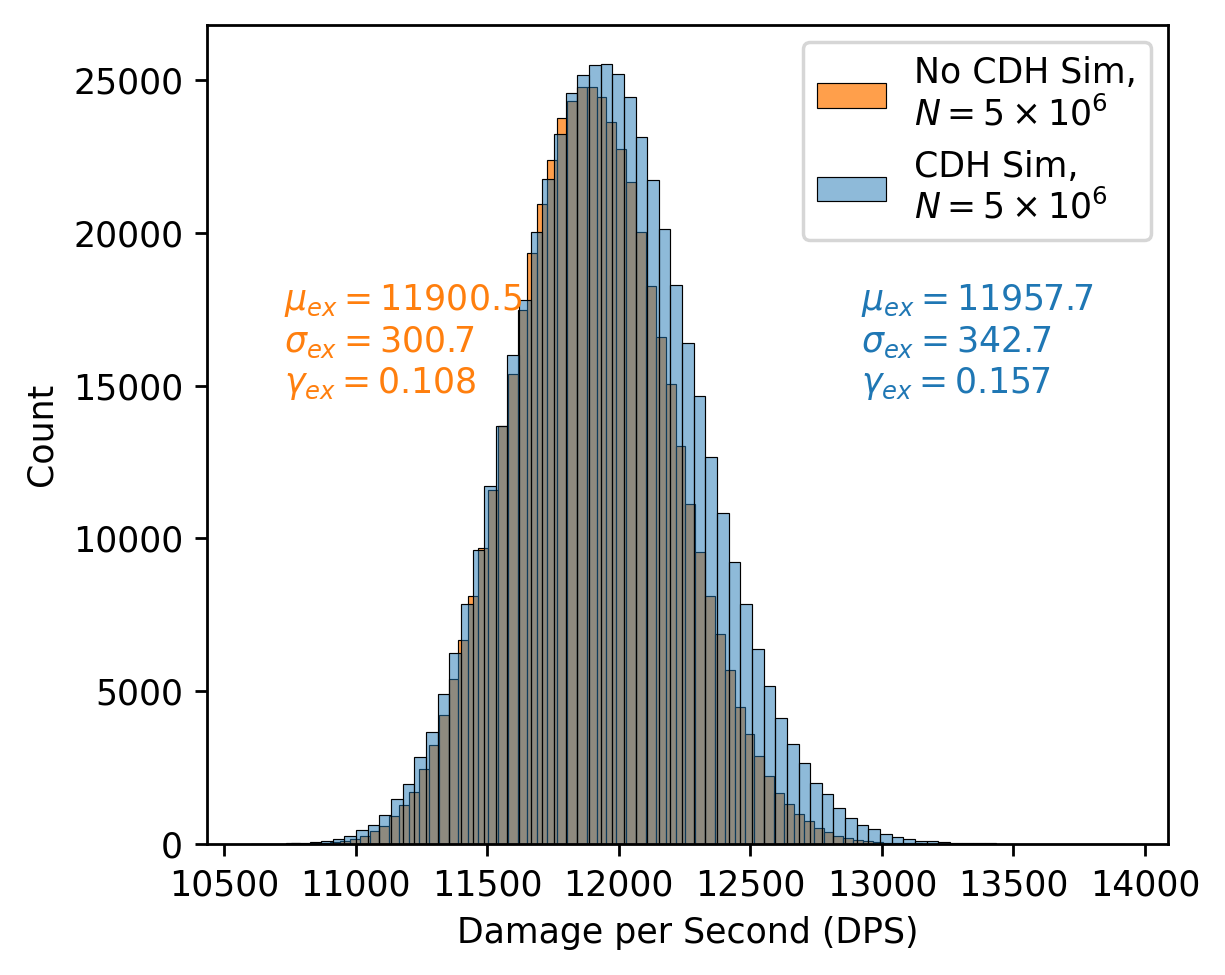

In [46]:
fig, ax = plt.subplots(1,1, figsize=(5,4), dpi=250, sharey=True)

sns.histplot(rotation_dmg_dist_noCDH * dmg2dps, bins=75, ax=ax, label='No CDH Sim,\n'+r'$N = 5 \times 10^6$', color='C1', alpha=0.75)
sns.histplot(rotation_dmg_dist * dmg2dps, bins=75, ax=ax, label='CDH Sim,\n'+r'$N = 5 \times 10^6$', color='C0', alpha=0.5)

ax.set_xlabel('Damage per Second (DPS)')
ax.legend()

anno2 = r'$\mu_{ex} = $' + '{:.1f}'.format(exact_mean_noCDH)
anno2 += '\n'
anno2 += r'$\sigma_{ex} = $' + '{:.1f}'.format(exact_std_noCDH)
anno2 += '\n'
anno2 += r'$\gamma_{ex} = $' + '{:.3f}'.format(exact_skew_noCDH)

anno1 = r'$\mu_{ex} = $' + '{:.1f}'.format(exact_mean)
anno1 += '\n'
anno1 += r'$\sigma_{ex} = $' + '{:.1f}'.format(exact_std)
anno1 += '\n'
anno1 += r'$\gamma_{ex} = $' + '{:.3f}'.format(exact_skew)

ax.annotate(anno1, xy=(0.68, 0.55), xycoords='axes fraction', color='C0')
ax.annotate(anno2, xy=(0.08, 0.55), xycoords='axes fraction', color='C1')
# ax.set_xlim([10000, 14100])
# ax.set_xticks(np.arange(10000, 15000, 1000))

plt.tight_layout()
plt.show()


# Example: 1-2-3 rotation with a DoT and 10% damage buff

In [85]:
# Det/Ten will enter here but I'm just assuming nice values
# because I dont want to code up everything needed to compute D2
d1 = 13000
d2 = 20000
d3 = 25000
d4 = 35000
d5 = 3000 # This is a dot

n1 = 25
n2 = 25
n3 = 25
n4 = 5
n5 = 75 # This is a dot

is_dot = [0, 0, 0, 0, 1]

d = np.array([d1, d2, d3, d4, d5])
n = np.array([n1, n2, n3, n4, n5])

# I think this is from 5.4 DRG BiS idk
crit = 4069
dh = 2919

p_c = crit_prob(crit)
p_d = direct_hit_prob(dh)

# Actually compute the proper crit rate and dmg modifier now
p = get_p_vector(p_c, p_d)

l_c = crit_dmg_multiplier(crit)
l_d = 125

# Persistent 10% dmg buff
b = [1.1]
# Convert total dmg dealt to dps, assume 2.50s gcd
n_hits = 75
gcd = 2.5

dmg2dps = 1/(2.5*n_hits)
p

array([0.419479, 0.157521, 0.307521, 0.115479])

### Little example illustrating what happens if 2 gcds are missed

In [48]:
# n[1:3] = 24
# exact_mean =        rotation_mean(d, n, l_c, l_d, p, is_dot) * dmg2dps
# exact_std  = np.sqrt(rotation_var(d, n, l_c, l_d, p, is_dot)) * dmg2dps
# exact_rel_std = exact_std / exact_mean
# exact_skew = rotation_skew(d, n, l_c, l_d, p, is_dot)

# print('Exact mean: {:5.3f} |'.format(exact_mean), 'Exact StD: {:5.3f} |'.format(exact_std), 'Exact Skew: {:1.3f}'.format(exact_skew))
# print('cv: {:0.4f}'.format(exact_rel_std))

### CH only to get skewness

In [49]:
# p_c = crit_prob(crit)
# p_d = direct_hit_prob(380)

# # p_bionm = get_p_vector2(p_c, p_d, keep_cd=False)
# p_bionm = get_p_vector(p_c, p_d)
# print(p)
# rotation_skew(d, n, l_c, l_d, p_bionm, is_dot)

Simulate damage distributions

In [50]:
print(p)
x_1 = np.random.multinomial(n[0], p, 500000)
x_2 = np.random.multinomial(n[1], p, 500000)
x_3 = np.random.multinomial(n[2], p, 500000)
x_4 = np.random.multinomial(n[3], p, 500000)
x_5 = np.random.multinomial(n[4], p, 500000)

rotation_dmg_dist =  hits2pot(x_1, l_c, l_d, d[0], b) + hits2pot(x_2, l_c, l_d, d[1], b) + hits2pot(x_3, l_c, l_d, d[2], b) + hits2pot(x_4, l_c, l_d, d[3], b) + dots2pot(x_5, l_c, l_d, d[4], b)

[0.419479 0.157521 0.307521 0.115479]


Compute exact moments and compare with sample estimates

In [51]:
x = rotation_dmg_dist * dmg2dps

exact_mean =        rotation_mean(d, n, l_c, l_d, p, is_dot, b*5) * dmg2dps
exact_std  = np.sqrt(rotation_var(d, n, l_c, l_d, p, is_dot, b*5)) * dmg2dps
exact_rel_std = exact_std / exact_mean
exact_skew = rotation_skew(d, n, l_c, l_d, p, is_dot, b*5)

print('Sim mean:   {:5.3f} |'.format(np.mean(x)), 'Sim StD:   {:5.3f} |'.format(np.std(x)), 'Sim Skew:   {:1.3f}'.format(skew(x)))
print('Exact mean: {:5.3f} |'.format(exact_mean), 'Exact StD: {:5.3f} |'.format(exact_std), 'Exact Skew: {:1.3f}'.format(exact_skew))
print('cv: {:0.4f}'.format(exact_rel_std))

Sim mean:   14041.964 | Sim StD:   384.773 | Sim Skew:   0.124
Exact mean: 14041.576 | Exact StD: 385.363 | Exact Skew: 0.127
cv: 0.0274


## No critical-direct hits

In [87]:
# Det/Ten will enter here but I'm just assuming nice values
# because I dont want to code up everything needed to compute D2
d1 = 13000
d2 = 20000
d3 = 25000
d4 = 35000
d5 = 3000 # This is a dot

n1 = 25
n2 = 25
n3 = 25
n4 = 5
n5 = 75 # This is a dot

is_dot = [0, 0, 0, 0, 1]

d = np.array([d1, d2, d3, d4, d5])
n = np.array([n1, n2, n3, n4, n5])

# I think this is from 5.4 DRG BiS idk
crit = 4069
dh = 2919

l_c = crit_dmg_multiplier(crit)
l_d = 125

# Persistent 10% dmg buff
b = [1.1]
# Convert total dmg dealt to dps, assume 2.50s gcd
n_hits = 75
gcd = 2.5

dmg2dps = 1/(2.5*n_hits)

p_c = crit_prob(crit)
p_d = direct_hit_prob(dh)

b = [1.1]
p = get_p_vector(p_c, p_d, keep_cd=False)
p

array([0.304, 0.273, 0.423, 0.   ])

In [88]:
print(p)
x_1_noCDH = np.random.multinomial(n[0], p, 500000)
x_2_noCDH = np.random.multinomial(n[1], p, 500000)
x_3_noCDH = np.random.multinomial(n[2], p, 500000)
x_4_noCDH = np.random.multinomial(n[3], p, 500000)
x_5_noCDH = np.random.multinomial(n[4], p, 500000)

rotation_dmg_dist_noCDH =  hits2pot(x_1_noCDH, l_c, l_d, d[0], b) + hits2pot(x_2_noCDH, l_c, l_d, d[1], b) + hits2pot(x_3_noCDH, l_c, l_d, d[2], b) + hits2pot(x_4_noCDH, l_c, l_d, d[3], b) + dots2pot(x_5_noCDH, l_c, l_d, d[4], b)

[0.304 0.273 0.423 0.   ]


In [89]:
x = rotation_dmg_dist_noCDH * dmg2dps

exact_mean_noCDH =      rotation_mean(d, n, l_c, l_d, p, is_dot, b*5) * dmg2dps
exact_std_noCDH = np.sqrt(rotation_var(d, n, l_c, l_d, p, is_dot, b*5)) * dmg2dps
exact_rel_std_noCDH = exact_std_noCDH / exact_mean_noCDH
exact_skew_noCDH = rotation_skew(d, n, l_c, l_d, p, is_dot, b*5)


print('Sim mean:   {:5.3f} |'.format(np.mean(x)), 'Sim StD:   {:5.3f} |'.format(np.std(x)),  'Sim Skew:   {:1.3f}'.format(skew(x)))
print('Exact mean: {:5.3f} |'.format(exact_mean_noCDH), 'Exact StD: {:5.3f} |'.format(exact_std_noCDH), 'Exact Skew: {:1.3f}'.format(exact_skew_noCDH))
print('cv: {:0.4f}'.format(exact_rel_std_noCDH))

Sim mean:   13846.770 | Sim StD:   269.350 | Sim Skew:   0.050
Exact mean: 13846.391 | Exact StD: 269.822 | Exact Skew: 0.048
cv: 0.0195


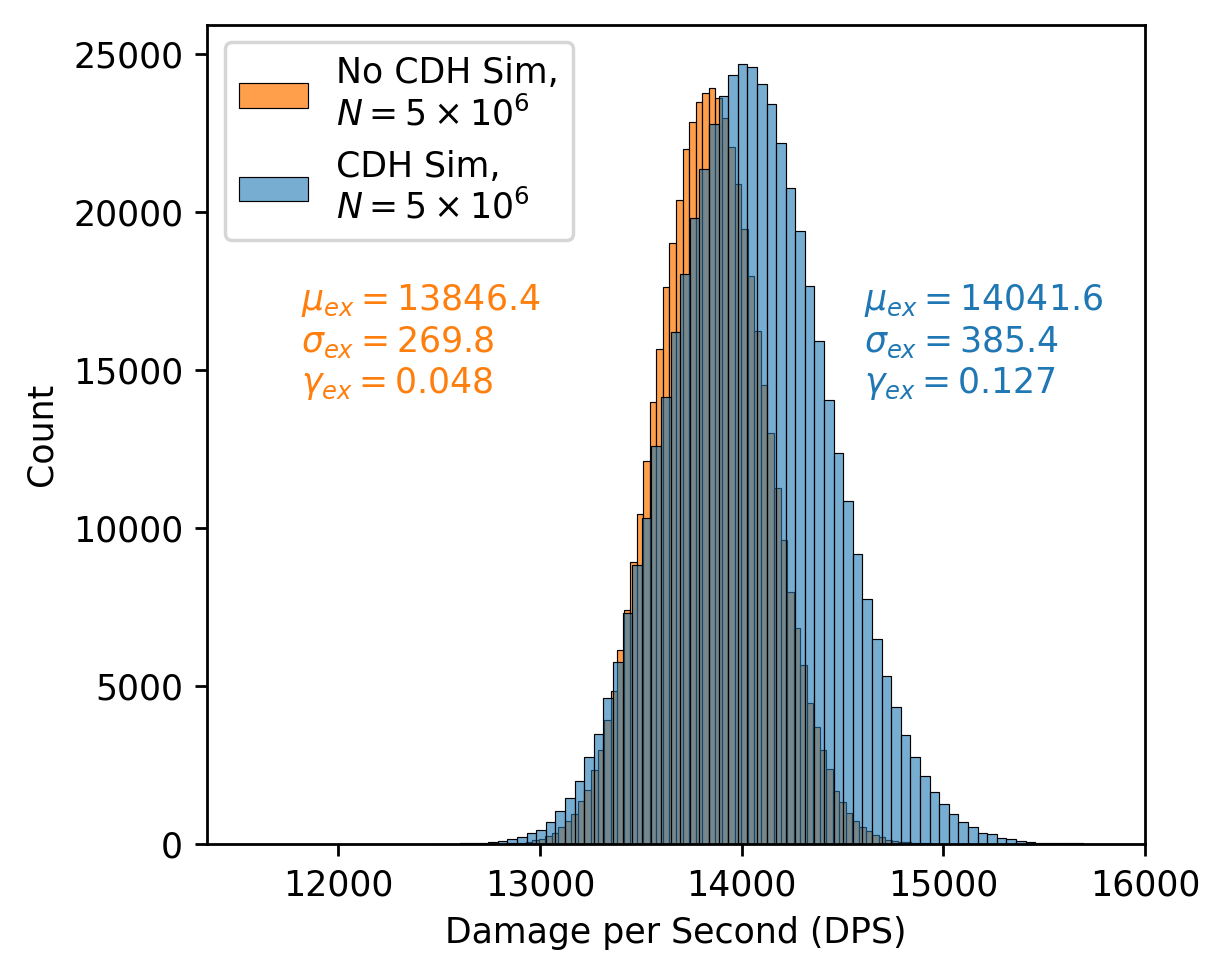

In [90]:
fig, ax = plt.subplots(1,1, figsize=(5,4), dpi=250, sharey=True)

dmg2dps = 1/(2.5*n_hits)

sns.histplot(rotation_dmg_dist_noCDH * dmg2dps, bins=75, ax=ax, label='No CDH Sim,\n'+r'$N = 5 \times 10^6$', color='C1')
sns.histplot(rotation_dmg_dist * dmg2dps, bins=75, ax=ax, label='CDH Sim,\n'+r'$N = 5 \times 10^6$', color='C0', alpha=0.6)

ax.set_xlabel('Damage per Second (DPS)')
ax.legend()

anno2 = r'$\mu_{ex} = $' + '{:.1f}'.format(exact_mean_noCDH)
anno2 += '\n'
anno2 += r'$\sigma_{ex} = $' + '{:.1f}'.format(exact_std_noCDH)
anno2 += '\n'
anno2 += r'$\gamma_{ex} = $' + '{:.3f}'.format(exact_skew_noCDH)

anno1 = r'$\mu_{ex} = $' + '{:.1f}'.format(exact_mean)
anno1 += '\n'
anno1 += r'$\sigma_{ex} = $' + '{:.1f}'.format(exact_std)
anno1 += '\n'
anno1 += r'$\gamma_{ex} = $' + '{:.3f}'.format(exact_skew)

ax.annotate(anno1, xy=(0.7, 0.55), xycoords='axes fraction', color='C0')
ax.annotate(anno2, xy=(0.1, 0.55), xycoords='axes fraction', color='C1')


ax.set_xlim([11350, 16000])
plt.tight_layout()
plt.show()

## Scanning DH and CH rates

In [56]:
def rel_std_scan(ch, dh, d2, n, del_CDH=False):
    """
    Get the coefficient of variation for a given pair of critical hit and direct hit stat

    inputs:
    ch: int, critical hit state
    dh: int, direct hit rate stat
    d2: float, D2 value of an attack
    n: int, number of hits
    del_CDH: bool, whether to set the probability of a critical-direct hit to 0

    returns:
    cofficient of variation
    """
    p_c = crit_prob(ch)
    p_d = direct_hit_prob(dh)

    if del_CDH:
        p = get_p_vector(p_c, p_d, keep_cd=False)

    else:
        p = get_p_vector(p_c, p_d)

    l_c = crit_dmg_multiplier(ch)
    l_d = 125.
    mean =       (skill_mean(d2, n, l_c, l_d, p)) * dmg2dps
    std  = np.sqrt(skill_var(d2, n, l_c, l_d, p)) * dmg2dps
    return std / mean

def skew_skan(ch, dh, d2, n, del_CDH=False):
    """
    Get the coefficient of variation for a given pair of critical hit and direct hit stat

    inputs:
    ch: int, critical hit state
    dh: int, direct hit rate stat
    d2: float, D2 value of an attack
    n: int, number of hits
    del_CDH: bool, whether to set the probability of a critical-direct hit to 0

    returns:
    Skewness
    """

    p_c = crit_prob(ch)
    p_d = direct_hit_prob(dh)

    if del_CDH:
        p = get_p_vector(p_c, p_d, keep_cd=False)

    else:
        p = get_p_vector(p_c, p_d)

    l_c = crit_dmg_multiplier(ch)
    l_d = 125

    return skill_skewness(d2, n, l_c, l_d, p)



In [57]:
ch = np.linspace(380, 4200, 15)
dh = np.linspace(380, 4200, 15)

CH, DH = np.meshgrid(ch, dh)

n_hits = 50
d2 = 10000
dmg2dps = 1/(2.5*n_hits)

rel_std = [[rel_std_scan(x, y, d2, n_hits) for x in ch] for y in dh]
rel_std_noCDH = [[rel_std_scan(x, y, d2, n_hits, True) for x in ch] for y in dh]

# This is where the inefficiency of computing moments multiple times really becomes apparent.
# Each one only takes about 3 seconds, but when you have to repeat it 15 x 15 times it becomes pretty slow.
# Only computing each moment once time would probably make this ~3x faster
skew = [[skew_skan(x, y, d2, n_hits) for x in ch] for y in dh]
skew_noCDH = [[skew_skan(x, y, d2, n_hits, True) for x in ch] for y in dh]

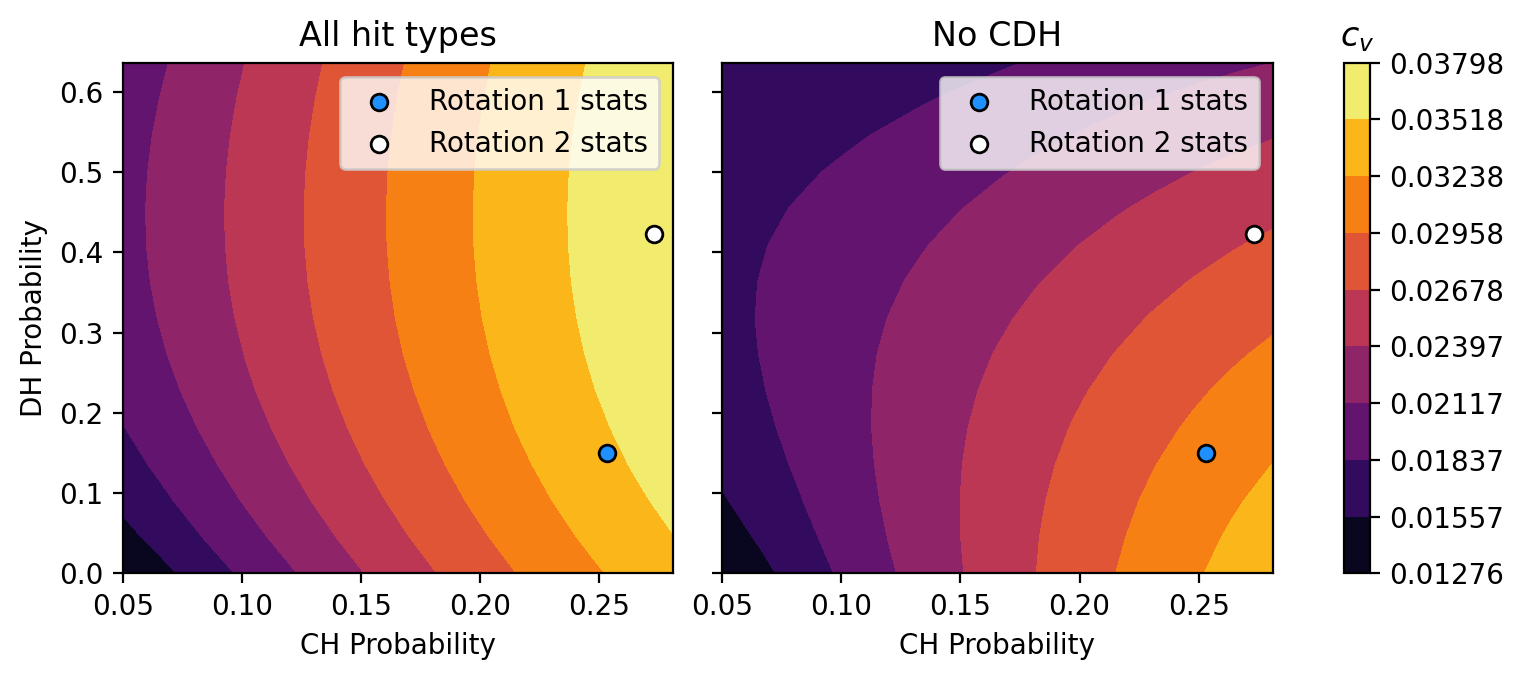

In [58]:
r1 = [crit_prob(3731), direct_hit_prob(1280)]
r2 = [crit_prob(4069), direct_hit_prob(2919)]

min_cv = np.min([rel_std, rel_std_noCDH])
max_cv = np.max([rel_std, rel_std_noCDH])
levels = np.linspace(min_cv, max_cv, 10)

fig, ax = plt.subplots(1,2, figsize=(8,3.5), sharey=True, dpi=200)

im = ax[0].contourf(crit_prob(CH), direct_hit_prob(DH), rel_std, cmap='inferno', vmin=min_cv, vmax=max_cv, levels=levels)
ax[0].scatter(r1[0], r1[1], label='Rotation 1 stats', c='dodgerblue', edgecolors='k')
ax[0].scatter(r2[0], r2[1], label='Rotation 2 stats', c='w', edgecolors='k')
ax[0].legend()
ax[0].set_title('All hit types')
# ax[0].colorbar()
ax[1].contourf(crit_prob(CH), direct_hit_prob(DH), rel_std_noCDH, cmap='inferno', vmin=min_cv, vmax=max_cv, levels=levels)
ax[1].scatter(r1[0], r1[1], label='Rotation 1 stats', c='dodgerblue', edgecolors='k')
ax[1].scatter(r2[0], r2[1], label='Rotation 2 stats', c='w', edgecolors='k')
ax[1].legend()
ax[0].set_ylabel('DH Probability')
ax[0].set_xlabel('CH Probability')
ax[1].set_xlabel('CH Probability')
ax[1].set_title('No CDH')

fig.tight_layout()
cbar = fig.colorbar(im, ax=ax.ravel().tolist())
cbar.ax.set_title('$c_v$')

# plt.tight_layout()
plt.show()

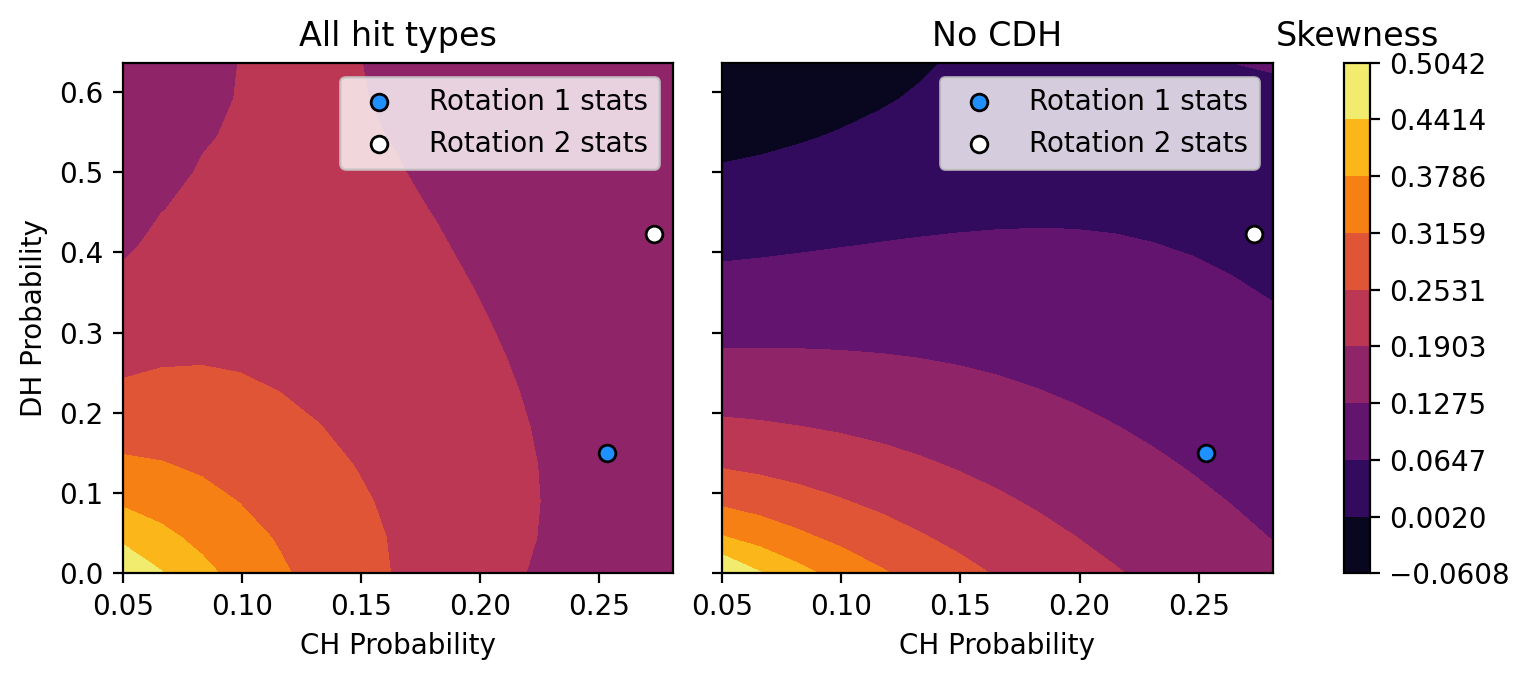

In [59]:
r1 = [crit_prob(3731), direct_hit_prob(1280)]
r2 = [crit_prob(4069), direct_hit_prob(2919)]

fig, ax = plt.subplots(1,2, figsize=(8,3.5), sharey=True, dpi=200)

min_skew = np.min([skew, skew_noCDH])
max_skew = np.max([skew, skew_noCDH])
levels = np.linspace(min_skew,max_skew,10)


im = ax[0].contourf(crit_prob(CH), direct_hit_prob(DH), skew, cmap='inferno', vmin=min_skew, vmax=max_skew, levels=levels)
ax[0].scatter(r1[0], r1[1], label='Rotation 1 stats', c='dodgerblue', edgecolors='k')
ax[0].scatter(r2[0], r2[1], label='Rotation 2 stats', c='w', edgecolors='k')
ax[0].legend()
ax[0].set_title('All hit types')

ax[1].contourf(crit_prob(CH), direct_hit_prob(DH), skew_noCDH, cmap='inferno', vmin=min_skew, vmax=max_skew, levels=levels)
ax[1].scatter(r1[0], r1[1], label='Rotation 1 stats', c='dodgerblue', edgecolors='k')
ax[1].scatter(r2[0], r2[1], label='Rotation 2 stats', c='w', edgecolors='k')
ax[1].legend()
ax[0].set_ylabel('DH Probability')
ax[0].set_xlabel('CH Probability')
ax[1].set_xlabel('CH Probability')
ax[1].set_title('No CDH')

fig.tight_layout()
cbar = fig.colorbar(im, ax=ax.ravel().tolist())
cbar.ax.set_title('Skewness')

# plt.tight_layout()
plt.show()

### Skewness with total number of hits

This also takes a while because enumerating over all hit types that sum to $n$ when $n > 100$ is pretty big.

In [ ]:
n = np.arange(151, step=5)
r1 = [crit_prob(3731), direct_hit_prob(1280)]
r2 = [crit_prob(4069), direct_hit_prob(2919)]

p1 = get_p_vector(r1[0], r1[1], keep_cd=True)
p2 = get_p_vector(r2[0], r2[1], keep_cd=True)

skew_r1 = [skill_skewness(10000, x, crit_dmg_multiplier(3731), 125, p1) for x in n]
skew_r2 = [skill_skewness(10000, x, crit_dmg_multiplier(4069), 125, p2) for x in n]

p1_noCDH = get_p_vector(r1[0], r1[1], keep_cd=False)
p2_noCDH = get_p_vector(r2[0], r2[1], keep_cd=False)

skew_r1_noCDH = [skill_skewness(10000, x, crit_dmg_multiplier(3731), 125, p1_noCDH) for x in n]
skew_r2_noCDH = [skill_skewness(10000, x, crit_dmg_multiplier(4069), 125, p2_noCDH) for x in n]

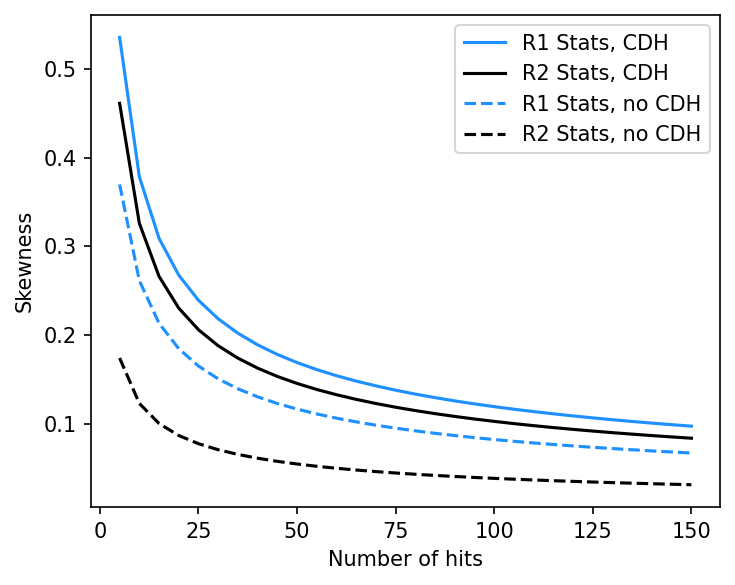

In [61]:
fig, ax = plt.subplots(1,1, figsize=(5, 4), dpi=150)

ax.plot(n, skew_r1, label='R1 Stats, CDH', color='dodgerblue')
ax.plot(n, skew_r2, label='R2 Stats, CDH', color='k')
ax.plot(n, skew_r1_noCDH, linestyle='--', label='R1 Stats, no CDH', color='dodgerblue')
ax.plot(n, skew_r2_noCDH, linestyle='--', label='R2 Stats, no CDH', color='k')

ax.legend()
ax.set_xlabel('Number of hits')
ax.set_ylabel('Skewness')

ax.set_xticks(np.arange(0,151,25))

plt.tight_layout()
plt.show()